Chapter 7
# EWMA协方差矩阵
Book_6《数据有道》 | 鸢尾花书：从加减乘除到机器学习

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
# pip install pandas_datareader
import seaborn as sns
from itertools import combinations

## 下载数据

In [21]:
df = pdr.data.DataReader(['DGS6MO','DGS1',
                          'DGS2','DGS5',
                          'DGS7','DGS10',
                          'DGS20','DGS30'], 
                          data_source='fred', 
                          start='01-01-2022', 
                          end='12-31-2022')
df = df.dropna()
df.to_csv('IR_data.csv')
df.to_pickle('IR_data.pkl')
# 如果无法下载数据，请用pandas.read_csv() 或 pandas.read_pickle() 读取配套文件

In [52]:
df

,0.5 yr,1 yr,2 yr,5 yr,7 yr,10 yr,20 yr,30 yr
DATE,,,,,,,,
2022-01-03,0.22,0.40,0.78,1.37,1.55,1.63,2.05,2.01
2022-01-04,0.22,0.38,0.77,1.37,1.57,1.66,2.10,2.07
2022-01-05,0.22,0.41,0.83,1.43,1.62,1.71,2.12,2.09
2022-01-06,0.23,0.45,0.88,1.47,1.66,1.73,2.12,2.09
2022-01-07,0.24,0.43,0.87,1.50,1.69,1.76,2.15,2.11
...,...,...,...,...,...,...,...,...
2022-12-23,4.67,4.66,4.31,3.86,3.83,3.75,3.99,3.82
2022-12-27,4.76,4.75,4.32,3.94,3.93,3.84,4.10,3.93
2022-12-28,4.75,4.71,4.31,3.97,3.97,3.88,4.13,3.98


<Axes: xlabel='DATE'>

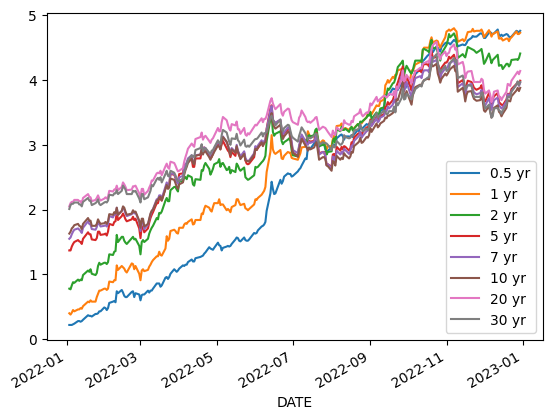

In [51]:
df.plot()

In [22]:
# 修改数据帧列标签
df = df.rename(columns={'DGS6MO': '0.5 yr', 
                        'DGS1': '1 yr',
                        'DGS2': '2 yr',
                        'DGS5': '5 yr',
                        'DGS7': '7 yr',
                        'DGS10': '10 yr',
                        'DGS20': '20 yr',
                        'DGS30': '30 yr'})

In [23]:
# 计算日收益率
X_df = df.pct_change()
X_df = X_df.dropna()

In [50]:
X_df

,0.5 yr,1 yr,2 yr,5 yr,7 yr,10 yr,20 yr,30 yr
DATE,,,,,,,,
2022-01-04,0.000000,-0.050000,-0.012821,0.000000,0.012903,0.018405,0.024390,0.029851
2022-01-05,0.000000,0.078947,0.077922,0.043796,0.031847,0.030120,0.009524,0.009662
2022-01-06,0.045455,0.097561,0.060241,0.027972,0.024691,0.011696,0.000000,0.000000
2022-01-07,0.043478,-0.044444,-0.011364,0.020408,0.018072,0.017341,0.014151,0.009569
2022-01-10,0.166667,0.069767,0.057471,0.020000,0.011834,0.011364,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2022-12-23,0.002146,0.004310,0.016509,0.018470,0.015915,0.021798,0.020460,0.024129
2022-12-27,0.019272,0.019313,0.002320,0.020725,0.026110,0.024000,0.027569,0.028796
2022-12-28,-0.002101,-0.008421,-0.002315,0.007614,0.010178,0.010417,0.007317,0.012723


<Axes: xlabel='DATE'>

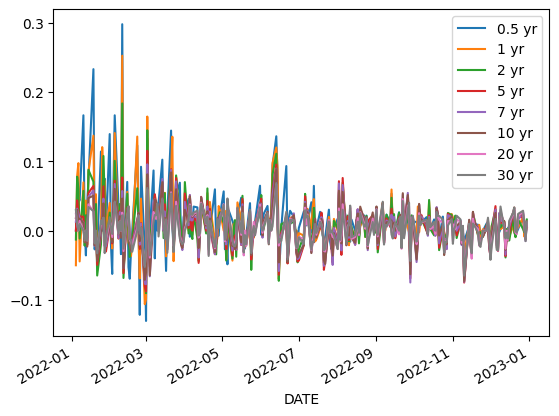

In [53]:
X_df.plot()

In [5]:
# 自定义函数计算EWMA协方差矩阵
def EWMA_cov(df, decay, demean = False):
    if demean:
        df = df.sub(df.mean())
    
    Data_array = df.to_numpy()
    N = len(df)
    
    if decay == 1:
        w_vec = np.ones((N,1))/(N-1)
    else:
        l_vec = np.arange(N)[::-1]
        w_vec = (1 - decay)/(1 - decay ** N) * decay ** l_vec
        w_vec = w_vec.reshape(-1,1)
    
    Data_array_weighted = Data_array * np.sqrt(w_vec)
    
    COV = Data_array_weighted.T @ Data_array_weighted
    return COV

# 自定义函数计算EWMA相关性系数矩阵
def EWMA_corr(df,decay,demean = False):
    
    COV = EWMA_cov(df, decay, demean)
    scaling = np.sqrt(np.diag(1/np.diag(COV)))
    
    CORR = scaling @ COV @ scaling
    
    return CORR


In [6]:
# 比较结果
EWMA_cov(X_df,0.9999,demean = True)

array([[0.00190344, 0.00126441, 0.00096755, 0.00072362, 0.00064422,
        0.00055689, 0.00035777, 0.00034067],
       [0.00126441, 0.00152806, 0.00115427, 0.00087936, 0.00077943,
        0.00067413, 0.00040402, 0.00039019],
       [0.00096755, 0.00115427, 0.00113392, 0.00091903, 0.00082137,
        0.00071751, 0.00044595, 0.00042766],
       [0.00072362, 0.00087936, 0.00091903, 0.00092012, 0.00086714,
        0.00078633, 0.00052552, 0.00051461],
       [0.00064422, 0.00077943, 0.00082137, 0.00086714, 0.00084629,
        0.00077939, 0.00054096, 0.0005338 ],
       [0.00055689, 0.00067413, 0.00071751, 0.00078633, 0.00077939,
        0.00074207, 0.00053182, 0.00053364],
       [0.00035777, 0.00040402, 0.00044595, 0.00052552, 0.00054096,
        0.00053182, 0.0004318 , 0.00043641],
       [0.00034067, 0.00039019, 0.00042766, 0.00051461, 0.0005338 ,
        0.00053364, 0.00043641, 0.00045767]])

In [7]:
EWMA_cov_df = pd.DataFrame(data = EWMA_cov(X_df,0.9999,demean = True),
                            index = X_df.columns,
                            columns = X_df.columns)

In [8]:
EWMA_cov_df

,0.5 yr,1 yr,2 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0.5 yr,0.001903,0.001264,0.000968,0.000724,0.000644,0.000557,0.000358,0.000341
1 yr,0.001264,0.001528,0.001154,0.000879,0.000779,0.000674,0.000404,0.000390
2 yr,0.000968,0.001154,0.001134,0.000919,0.000821,0.000718,0.000446,0.000428
5 yr,0.000724,0.000879,0.000919,0.000920,0.000867,0.000786,0.000526,0.000515
7 yr,0.000644,0.000779,0.000821,0.000867,0.000846,0.000779,0.000541,0.000534
10 yr,0.000557,0.000674,0.000718,0.000786,0.000779,0.000742,0.000532,0.000534
20 yr,0.000358,0.000404,0.000446,0.000526,0.000541,0.000532,0.000432,0.000436
30 yr,0.000341,0.000390,0.000428,0.000515,0.000534,0.000534,0.000436,0.000458


In [9]:
X_df.cov()

,0.5 yr,1 yr,2 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0.5 yr,0.001926,0.001279,0.000978,0.000731,0.000651,0.000562,0.000361,0.000344
1 yr,0.001279,0.001545,0.001166,0.000888,0.000786,0.000680,0.000408,0.000394
2 yr,0.000978,0.001166,0.001144,0.000926,0.000828,0.000723,0.000449,0.000431
5 yr,0.000731,0.000888,0.000926,0.000926,0.000873,0.000791,0.000529,0.000518
7 yr,0.000651,0.000786,0.000828,0.000873,0.000852,0.000784,0.000544,0.000537
10 yr,0.000562,0.000680,0.000723,0.000791,0.000784,0.000747,0.000535,0.000537
20 yr,0.000361,0.000408,0.000449,0.000529,0.000544,0.000535,0.000434,0.000439
30 yr,0.000344,0.000394,0.000431,0.000518,0.000537,0.000537,0.000439,0.000460


In [10]:
pd.DataFrame(data = EWMA_cov(X_df,1,demean = True),
                            index = X_df.columns,
                            columns = X_df.columns)

,0.5 yr,1 yr,2 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0.5 yr,0.001926,0.001279,0.000978,0.000731,0.000651,0.000562,0.000361,0.000344
1 yr,0.001279,0.001545,0.001166,0.000888,0.000786,0.000680,0.000408,0.000394
2 yr,0.000978,0.001166,0.001144,0.000926,0.000828,0.000723,0.000449,0.000431
5 yr,0.000731,0.000888,0.000926,0.000926,0.000873,0.000791,0.000529,0.000518
7 yr,0.000651,0.000786,0.000828,0.000873,0.000852,0.000784,0.000544,0.000537
10 yr,0.000562,0.000680,0.000723,0.000791,0.000784,0.000747,0.000535,0.000537
20 yr,0.000361,0.000408,0.000449,0.000529,0.000544,0.000535,0.000434,0.000439
30 yr,0.000344,0.000394,0.000431,0.000518,0.000537,0.000537,0.000439,0.000460


## 滚动EWMA协方差矩阵/相关性系数矩阵

In [24]:
decay = 0.97
rolling_EWMA_cov  = X_df.ewm(alpha = 1 - decay, adjust = False).cov()

In [25]:
rolling_EWMA_corr = X_df.ewm(alpha = 1 - decay, adjust = False).corr()

In [26]:
rolling_EWMA_corr.loc['2022-3-30']

,0.5 yr,1 yr,2 yr,5 yr,7 yr,10 yr,20 yr,30 yr
0.5 yr,1.000000,0.732174,0.758986,0.667839,0.618627,0.563289,0.453387,0.396249
1 yr,0.732174,1.000000,0.882799,0.771250,0.676001,0.609397,0.431530,0.367386
2 yr,0.758986,0.882799,1.000000,0.905706,0.826413,0.766140,0.614479,0.534469
5 yr,0.667839,0.771250,0.905706,1.000000,0.976421,0.943733,0.820573,0.751824
7 yr,0.618627,0.676001,0.826413,0.976421,1.000000,0.985409,0.907547,0.850153
10 yr,0.563289,0.609397,0.766140,0.943733,0.985409,1.000000,0.940438,0.900808
20 yr,0.453387,0.431530,0.614479,0.820573,0.907547,0.940438,1.000000,0.982643
30 yr,0.396249,0.367386,0.534469,0.751824,0.850153,0.900808,0.982643,1.000000


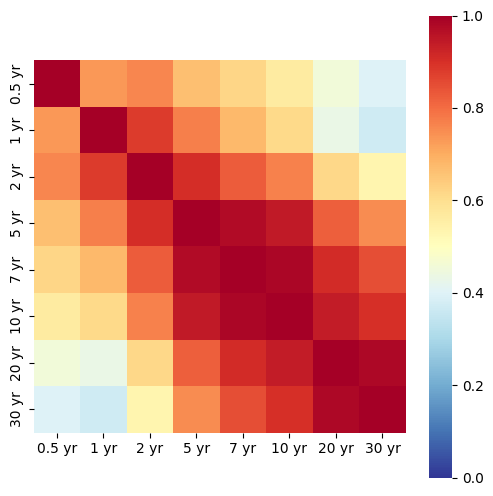

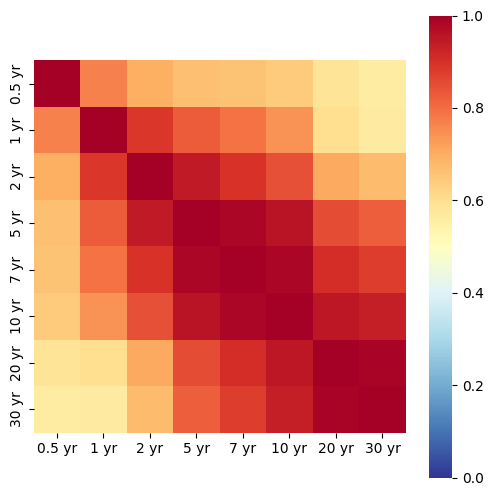

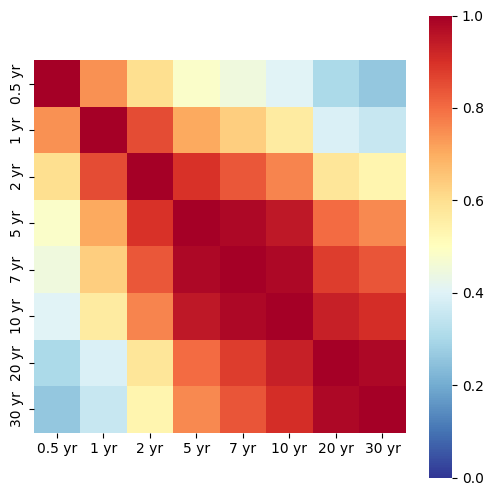

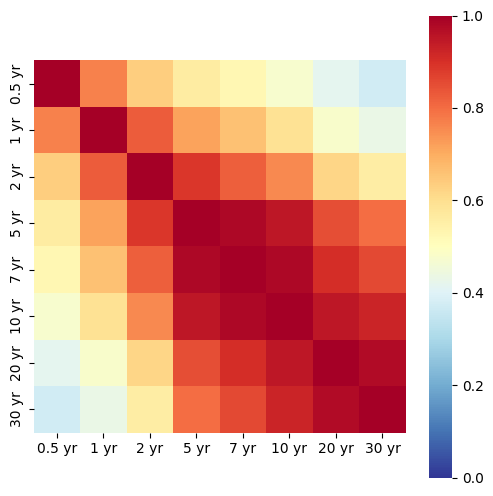

In [31]:
selected_dates = ['2022-3-30','2022-6-30','2022-9-30','2022-12-30']

for date_i in selected_dates:
    plt.figure(figsize = (6,6))
    sns.heatmap(rolling_EWMA_corr.loc[date_i], 
                square = True,
                cmap = 'RdYlBu_r', vmin = 0, vmax = 1)
    
    plt.savefig(date_i + '.svg')

## 成对相关性系数

In [32]:
rolling_EWMA_corr_ = rolling_EWMA_corr.unstack()

In [34]:
rolling_EWMA_corr_.head(5)

0.5 yr                                                              \
           0.5 yr      1 yr     10 yr      2 yr     20 yr     30 yr      5 yr   
DATE                                                                            
2022-01-04    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2022-01-05    NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2022-01-06    1.0  0.749292 -0.521943  0.618469 -0.853137 -0.826964  0.525732   
2022-01-07    1.0  0.536183 -0.440266  0.429623 -0.804116 -0.855492  0.595245   
2022-01-10    1.0  0.641982 -0.581224  0.607000 -0.803812 -0.785902  0.490426   

                          1 yr       ...     20 yr               30 yr  \
                7 yr    0.5 yr 1 yr  ...      5 yr      7 yr    0.5 yr   
DATE                                 ...                                 
2022-01-04       NaN       NaN  NaN  ...       NaN       NaN       NaN   
2022-01-05       NaN       NaN  1.0  ... -1.000000 -1.000000       NaN   
2022-01-06  0.515349  0.749292  1.0  ... -0.892295 -0.886739 -0.826964   
2022-01-07  0.501795  0.536183  1.0  ... -0.903337 -0.887156 -0.855492   
2022-01-10  0.081760  0.641982  1.0  ... -0.865762 -0.628377 -0.785902   

                                                                              
                1 yr     10 yr      2 yr     20 yr 30 yr      5 yr      7 yr  
DATE                                                                          
2022-01-04       NaN       NaN       NaN       NaN   NaN       NaN       NaN  
2022-01-05 -1.000000 -1.000000 -1.000000  1.000000   1.0 -1.000000 -1.000000  
2022-01-06 -0.991985 -0.047964 -0.953276  0.998835   1.0 -0.913043 -0.908016  
2022-01-07 -0.866274  0.000694 -0.824204  0.983279   1.0 -0.917830 -0.876354  
2022-01-10 -0.903538  0.277322 -0.873462  0.987818   1.0 -0.891845 -0.653673  

[5 rows x 64 columns]

In [35]:
list_tickers = list(X_df.columns)

In [36]:
rolling_EWMA_corr_.columns = ['_'.join(col).strip()
                              for col in rolling_EWMA_corr.unstack().columns.values]

In [38]:
pairs_kept = ['_'.join(l) for l in combinations(list_tickers,2)]

In [39]:
rolling_EWMA_corr_selected = rolling_EWMA_corr_[pairs_kept]

In [40]:
rolling_EWMA_corr_selected.head(5)

,0.5 yr_1 yr,0.5 yr_2 yr,0.5 yr_5 yr,0.5 yr_7 yr,0.5 yr_10 yr,0.5 yr_20 yr,0.5 yr_30 yr,1 yr_2 yr,1 yr_5 yr,1 yr_7 yr,...,5 yr_7 yr,5 yr_10 yr,5 yr_20 yr,5 yr_30 yr,7 yr_10 yr,7 yr_20 yr,7 yr_30 yr,10 yr_20 yr,10 yr_30 yr,20 yr_30 yr
DATE,,,,,,,,,,,,,,,,,,,,,
2022-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,...,1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
2022-01-06,0.749292,0.618469,0.525732,0.515349,-0.521943,-0.853137,-0.826964,0.983808,0.957261,0.953673,...,0.999926,0.451186,-0.892295,-0.913043,0.462005,-0.886739,-0.908016,0.000300,-0.047964,0.998835
2022-01-07,0.536183,0.429623,0.595245,0.501795,-0.440266,-0.804116,-0.855492,0.983685,0.893984,0.932557,...,0.987968,0.390989,-0.903337,-0.917830,0.433746,-0.887156,-0.876354,0.028347,0.000694,0.983279
2022-01-10,0.641982,0.607000,0.490426,0.081760,-0.581224,-0.803812,-0.785902,0.987963,0.889392,0.745795,...,0.902965,0.176499,-0.865762,-0.891845,0.425796,-0.628377,-0.653673,0.317494,0.277322,0.987818


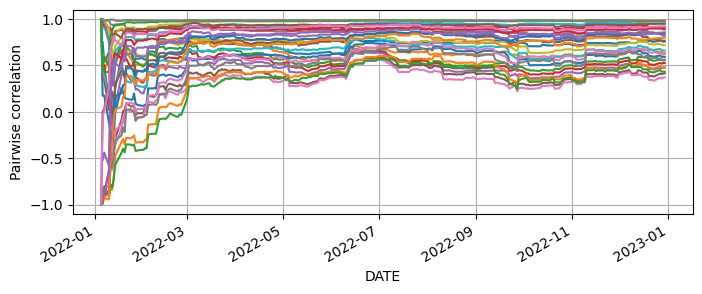

In [49]:
fig,ax = plt.subplots(figsize = (8,3))
rolling_EWMA_corr_selected.plot(legend = False, ax = ax)
plt.grid()
plt.ylabel('Pairwise correlation')
plt.savefig('EWMA相关性系数随时间变化.svg')